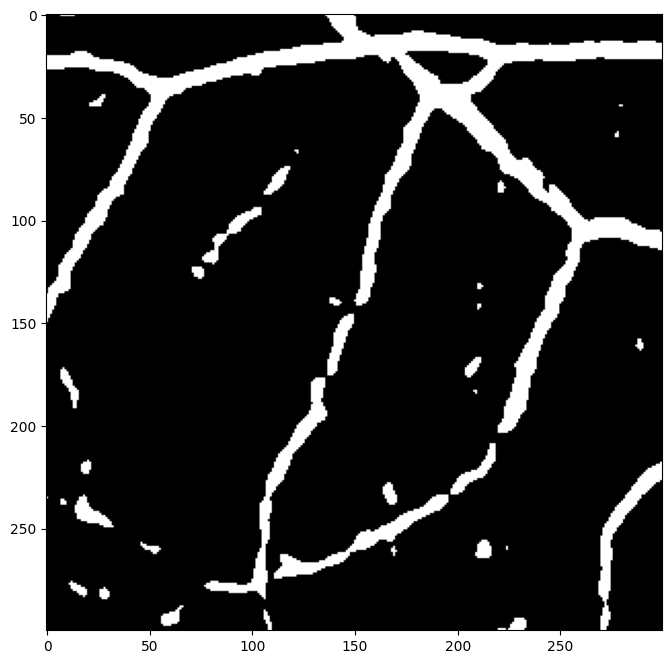

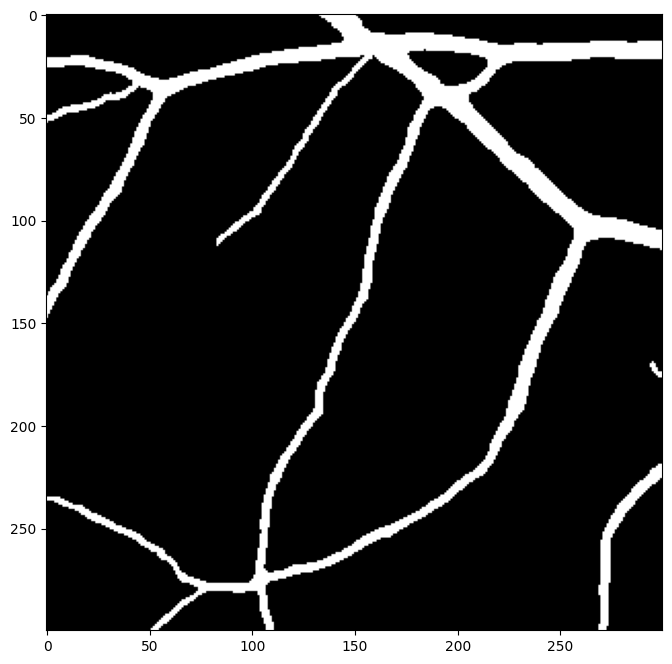

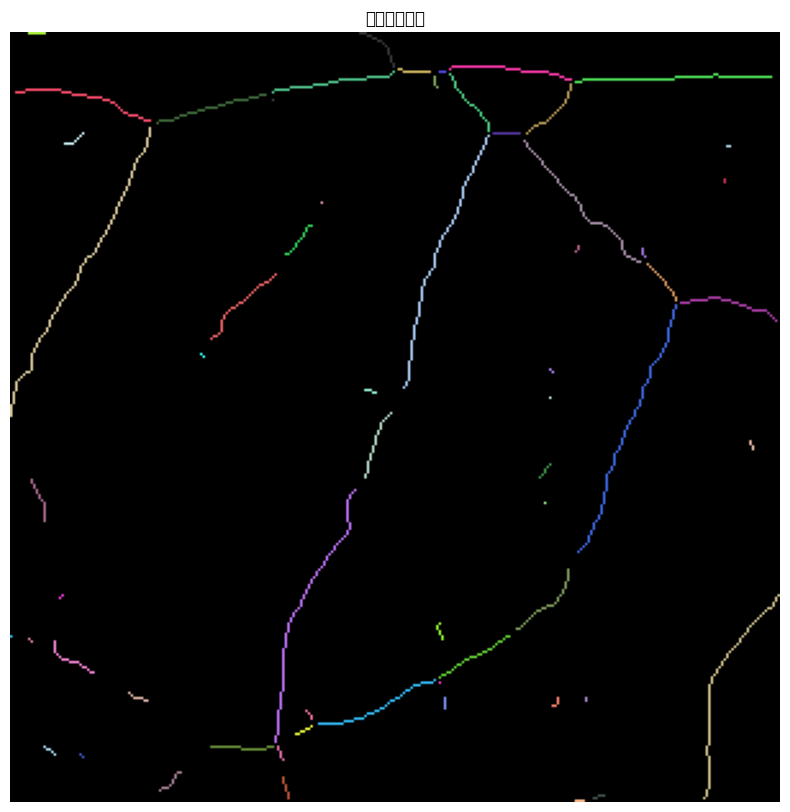

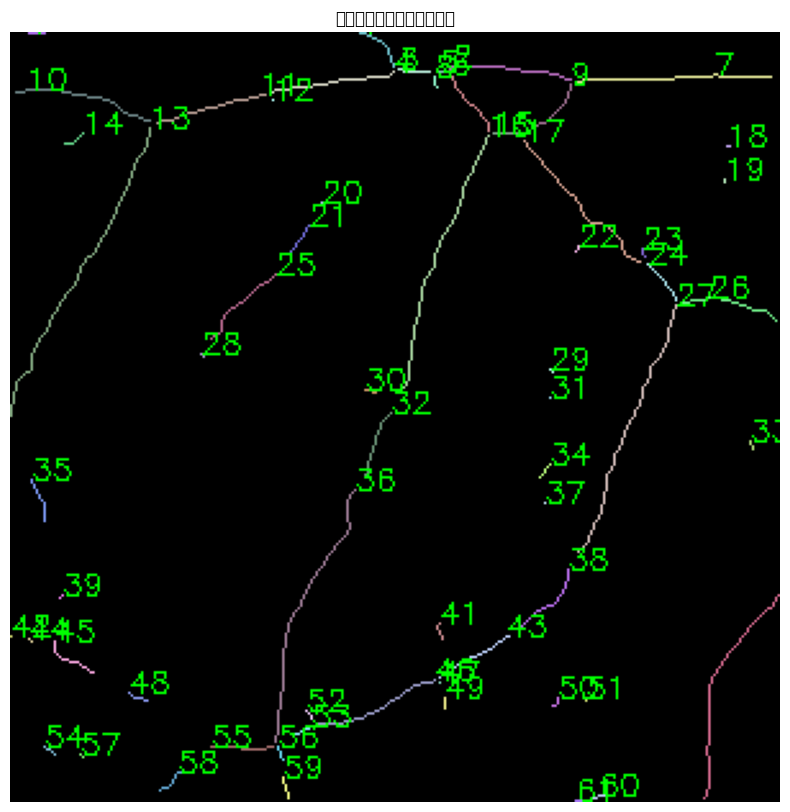

Segment 1:
  Endpoints: ((0, 7), (0, 13))
  Direction (k): 0.00 radians
  Length: 6.00 pixels
  Pixel Count: 7
----------------------------------------
Segment 2:
  Endpoints: ((0, 136), (13, 149))
  Direction (k): 0.79 radians
  Length: 18.38 pixels
  Pixel Count: 19
----------------------------------------
Segment 3:
  Endpoints: ((13, 172), (18, 218))
  Direction (k): 0.11 radians
  Length: 46.27 pixels
  Pixel Count: 48
----------------------------------------
Segment 4:
  Endpoints: ((14, 151), (15, 163))
  Direction (k): 0.08 radians
  Length: 12.04 pixels
  Pixel Count: 13
----------------------------------------
Segment 5:
  Endpoints: ((15, 149), (23, 102))
  Direction (k): 2.97 radians
  Length: 47.68 pixels
  Pixel Count: 48
----------------------------------------
Segment 6:
  Endpoints: ((15, 167), (15, 169))
  Direction (k): 0.00 radians
  Length: 2.00 pixels
  Pixel Count: 3
----------------------------------------
Segment 7:
  Endpoints: ((16, 171), (38, 186))
  Directi

/tmp/ipykernel_392901/805573755.py:839: UserWarning: Glyph 25913 (\N{CJK UNIFIED IDEOGRAPH-6539}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_392901/805573755.py:839: UserWarning: Glyph 36827 (\N{CJK UNIFIED IDEOGRAPH-8FDB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_392901/805573755.py:839: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_392901/805573755.py:839: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_392901/805573755.py:839: UserWarning: Glyph 27573 (\N{CJK UNIFIED IDEOGRAPH-6BB5}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_392901/805573755.py:839: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_392901/805573755.py:839: UserWarning: Glyph 21450 (\N{CJK UNIFIED IDEOGRAPH-53CA}) missing from current font.

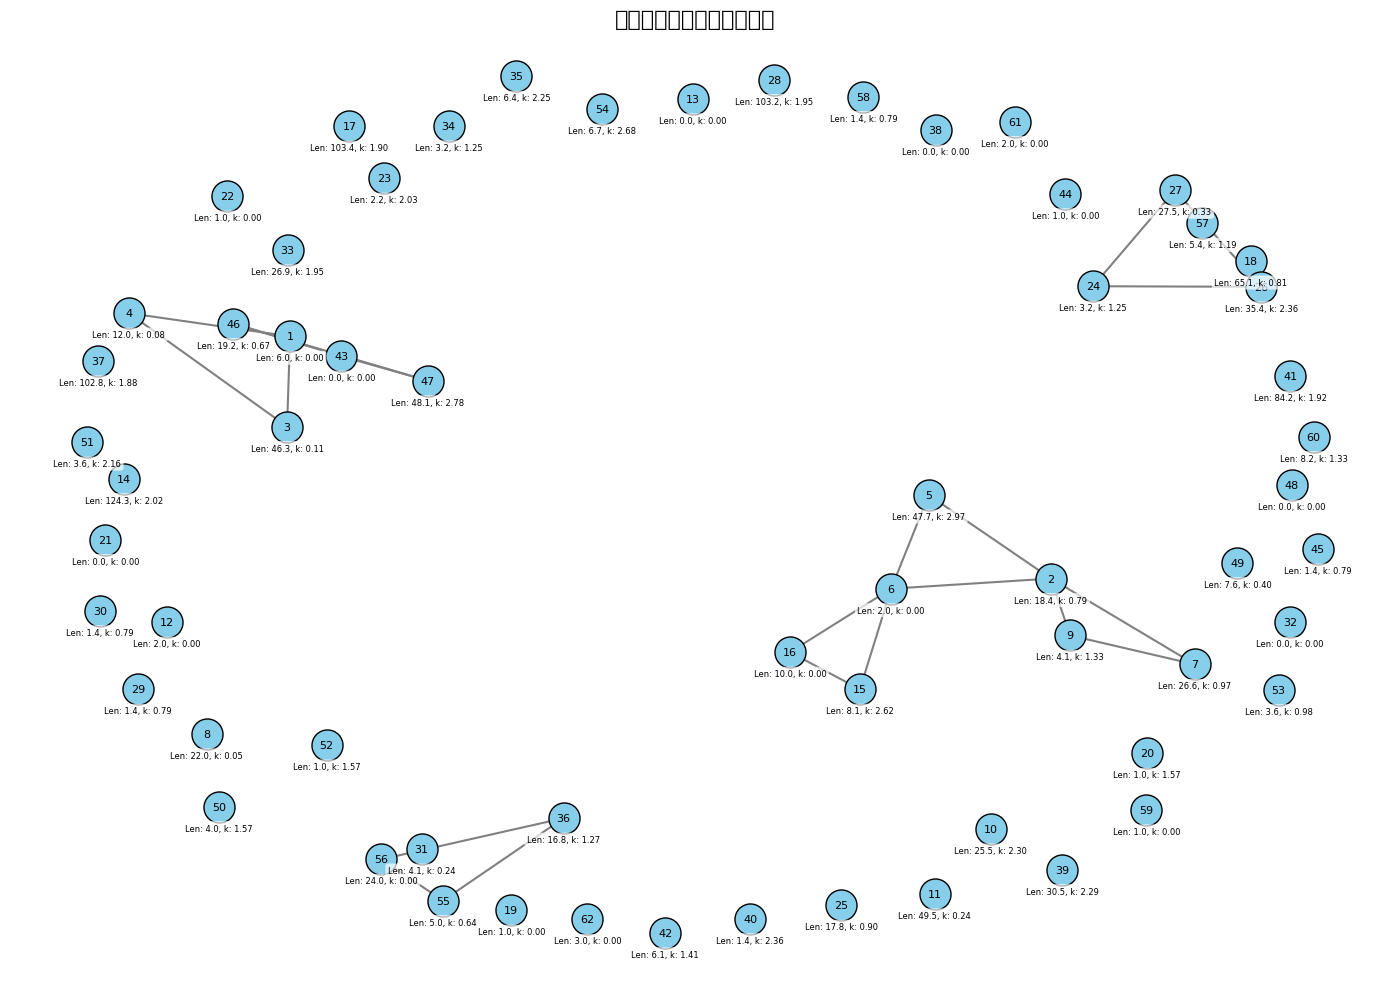

SystemExit: 0

In [3]:
###——————————————————————————————

import 差分约束 as DifferentialConnection
import matplotlib.pyplot as plt
from scipy.spatial import distance
from skimage.measure import label, regionprops
import numpy as np
from PIL import Image
import cv2
import numpy as np
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import random
import sys
import networkx as nx
from scipy.ndimage import distance_transform_edt
from scipy.spatial import distance
from numpy.polynomial.polynomial import Polynomial

def crop_image(image_path, position, size,isCrop=True):
    # 打开图像
    cropped_image = Image.open(image_path).convert('L') 
    if(isCrop):
      # 计算裁剪区域的边界
      left = position[0]
      upper = position[1]
      right = left + size[0]
      lower = upper + size[1]
      # 裁剪图像
      cropped_image = cropped_image.crop((left, upper, right, lower))
    return cropped_image

# 标识骨架图中的独立连通组件。
def identify_connected_components(skeleton):
    """
    标识骨架图中的独立连通组件。
    
    :param skeleton: 骨架图像
    :return: 各连通组件的坐标列表
    """
    # 使用标签标记连通组件
    labeled_image, num_labels = label(skeleton, connectivity=2, return_num=True)
    # 提取每个连通组件的坐标,这个地方需要再改进.
    components = [region.coords for region in regionprops(labeled_image)]
    return components

# 对[一个]连通组件进行路径段分割。
def segment_paths_in_component(component, max_segment_length=50):
    """
    对于一个连通组件，将其分割为路径段。
    这里假设一个简单的分段方法，实际中需根据应用调整。
    
    :param component: 单个连通组件的坐标
    :param max_segment_length: 每个段的最大长度
    :return: 该组件内的路径段列表
    """
    
    segments = []  # 存储分割后的路径段
    current_segment = [component[0]]  # 初始化当前段点

    # 遍历组件的每个点，根据距离分段
    for i in range(1, len(component)):
        prev_point = component[i - 1]
        current_point = component[i]
        
        # 计算当前段的长度
        segment_length = np.linalg.norm(np.array(current_point) - np.array(current_segment[0]))

        # 如果当前段的长度超过了最大段长，则将当前段存储并重新开始新的段
        if segment_length > max_segment_length:
            segments.append(current_segment)  # 保存当前段
            current_segment = [prev_point, current_point]  # 开始新段
        else:
            current_segment.append(current_point)  # 继续添加到当前段

    # 最后一个段加入
    segments.append(current_segment)
    
    # for i, segment in enumerate(segments):
    #     print(f"Segment {i}:")
    #     for coord in segment:
    #         print(f"  {coord}")
    #     print("-" * 40)  # 分隔线        
    
    return segments  ## Segment 0:[ 0 30]、[ 0 31]、[ 0 32]; Segment 1; Segment 2; ……

###**************************提取图的结构******************************###
def FIRST_segment_and_visualize_vessels(image):
    """
    读取图像，进行骨架提取，检测交点，将血管分段，并用不同颜色显示每个段。
    
    参数:
    - image_path: str, 输入图像的路径。
    """

    # 图像预处理：骨架提取
    def preprocess_image(img):
        _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        skeleton = skeletonize(binary // 255)
        return skeleton

    # 改进的交点检测，标记交点而不是删除
    def detect_junctions(skeleton):
        points = np.argwhere(skeleton)
        junctions = set()
        for point in points:
            x, y = point
            neighbors = skeleton[max(0, x-1):x+2, max(0, y-1):y+2]
            if np.sum(neighbors) > 3:  # 交点判定条件，可根据需求调整
                junctions.add((x, y))
        return list(junctions)

    # 构建图结构并优化交点与段的连通性
    def build_graph_and_segment(skeleton, junctions):
        G = nx.Graph()
        points = np.argwhere(skeleton)

        # 添加所有节点
        for point in points:
            G.add_node(tuple(point), is_junction=(tuple(point) in junctions))

        # 添加边，处理交点的连接方式
        for point in points:
            x, y = point
            neighbors = [(x + dx, y + dy) for dx in [-1, 0, 1] for dy in [-1, 0, 1] if (dx, dy) != (0, 0)]
            for n in neighbors:
                if G.has_node(n):
                    # ********************************* 交点连通策略：这个条件为 True 时，表示这两个节点（point 和 n）中至少有一个不是交点，允许添加边。**************************
                    if not (G.nodes[tuple(point)]['is_junction'] and G.nodes[n]['is_junction']):
                        G.add_edge((x, y), n)

        # 段的构建：从交点开始扩展段
        segments = []
        visited = set()

        def extend_segment(start_node):
            """扩展段，包含交点和普通节点"""
            segment = []
            stack = [start_node]
            while stack:
                node = stack.pop()
                if node not in visited:
                    visited.add(node)
                    segment.append(node)
                    for neighbor in G.neighbors(node):
                        # 保持交点和段的自然连通性
                        if neighbor not in visited:
                            stack.append(neighbor)
            return segment

        # 构建所有段，确保交点与其连接的段保持连通
        for node in G.nodes:
            if node not in visited:
                segment = extend_segment(node)
                if segment:
                    segments.append(segment)

        return segments

    # 可视化线段
    def visualize_segments(segments, image_shape):
        canvas = np.zeros(image_shape, dtype=np.uint8)
        colors = [(random.randint(50, 255), random.randint(50, 255), random.randint(50, 255)) for _ in range(len(segments))]
        for idx, segment in enumerate(segments):
            for point in segment:
                canvas[point[0], point[1]] = 255
        colored_image = cv2.cvtColor(canvas, cv2.COLOR_GRAY2BGR)
        for idx, segment in enumerate(segments):
            color = colors[idx]
            for point in segment:
                colored_image[point[0], point[1]] = color
        plt.figure(figsize=(10, 10))
        plt.imshow(colored_image)
        plt.axis('off')
        plt.title('血管分段结果')
        plt.show()

    # 主流程
    skeleton = preprocess_image(image)
    junctions = detect_junctions(skeleton)
    segments = build_graph_and_segment(skeleton, junctions)
    visualize_segments(segments, skeleton.shape) 
# 区域分段最终实现
def SECOND_segment_and_visualize_vessels(image):
    """
    读取图像，进行骨架提取，检测交点，将血管分段，并用不同颜色显示每个段。
    
    参数:
    - image_path: str, 输入图像的路径。
    """

    
    def preprocess_image(binary):
        """
        骨架提取，输入二值化图像，返回骨架图像。
        """
        skeleton = skeletonize(binary // 255)
        return skeleton

    def detect_junctions(skeleton):
        """
        改进的交点检测，标记交点而不是删除。
        """
        points = np.argwhere(skeleton)
        junctions = set()
        for point in points:
            x, y = point
            neighbors = skeleton[max(0, x-1):x+2, max(0, y-1):y+2]
            # 检测符合交点的条件
            if np.sum(neighbors) > 3:  # 判定条件，可根据需求调整
                junctions.add((x, y))
        return list(junctions)

    def build_graph_and_segment(skeleton, junctions):
        """
        构建图结构并优化交点与段的连通性。
        """
        G = nx.Graph()
        points = np.argwhere(skeleton)

        # 添加所有节点，并标记是否为交点
        for point in points:
            G.add_node(tuple(point), is_junction=(tuple(point) in junctions))

        # 添加边，避免在交点之间直接连通
        for point in points:
            x, y = point
            neighbors = [(x + dx, y + dy) for dx in [-1, 0, 1] for dy in [-1, 0, 1] if (dx, dy) != (0, 0)]
            for n in neighbors:
                if G.has_node(n):
                    # 交点连通策略：交点只与相邻段连接，不直接连接其他交点
                    if not (G.nodes[tuple(point)]['is_junction'] and G.nodes[n]['is_junction']):
                        G.add_edge((x, y), n)

        # 改进环处理：检测图中的环，并确保交点正确分段
        cycles = list(nx.cycle_basis(G))  # 查找所有环

        # 确保每个环在交点处分割成独立段
        for cycle in cycles:
            for node in cycle:
                # 如果环中节点是交点，移除此交点的所有边，强制分段
                if G.nodes[node]['is_junction']:
                    G.remove_node(node)

        # 段的构建：从交点开始扩展段
        segments = []
        visited = set()

        def extend_segment(start_node):
            """扩展段，包含普通节点和交点相邻节点"""
            segment = []
            stack = [start_node]
            while stack:
                node = stack.pop()
                if node not in visited:
                    visited.add(node)
                    segment.append(node)
                    for neighbor in G.neighbors(node):
                        # 避免交点直接连接不同段
                        if not G.nodes[neighbor]['is_junction'] or neighbor == start_node:
                            stack.append(neighbor)
            return segment

        # 构建所有段，确保交点将段正确分割
        for node in G.nodes:
            if node not in visited and not G.nodes[node]['is_junction']:
                segment = extend_segment(node)
                if segment:
                    segments.append(segment)

        return segments

    def assign_pixels_to_nearest_segment(segments, original_image):
        """
        根据原始图像像素，归属到最近的分段，返回分段标签矩阵。
        """
        label_map = np.zeros(original_image.shape, dtype=np.int32)
        dist_map = np.full(original_image.shape, np.inf)

        # 遍历每个段，计算段内骨架点到所有像素的距离
        for idx, segment in enumerate(segments):
            mask = np.zeros_like(original_image, dtype=np.uint8)
            for point in segment:
                if 0 <= point[0] < mask.shape[0] and 0 <= point[1] < mask.shape[1]:
                    mask[point[0], point[1]] = 1
            
            # 计算每个像素到当前段的距离
            dist_to_segment = distance_transform_edt(1 - mask)

            # 更新距离和段标签
            update_mask = dist_to_segment < dist_map
            dist_map[update_mask] = dist_to_segment[update_mask]
            label_map[update_mask] = idx + 1  # 确保标签从1开始
        
        # 仅在原始图像中有像素的地方返回标签值
        label_map[original_image == 0] = 0
        return label_map
    ###################### 这个是可视化分段
    def visualize_segments(segments, image_shape):
        """
        可视化线段。
        """
        canvas = np.zeros(image_shape, dtype=np.uint8)
        colors = [(random.randint(50, 255), random.randint(50, 255), random.randint(50, 255)) for _ in range(len(segments))]
        for idx, segment in enumerate(segments):
            for point in segment:
                canvas[point[0], point[1]] = 255
        colored_image = cv2.cvtColor(canvas, cv2.COLOR_GRAY2BGR)
        for idx, segment in enumerate(segments):
            color = colors[idx]
            for point in segment:
                colored_image[point[0], point[1]] = color
        plt.figure(figsize=(10, 10))
        plt.imshow(colored_image)
        plt.axis('off')
        plt.title('血管分段结果')
        plt.show()
        
    ########################## 这个是查看骨架上面的交叉点
    def highlight_junctions_on_skeleton(skeleton, junctions):
        """
        仅在骨架图上用不同灰度值标记交点位置，保持图像为黑白。

        参数:
        - skeleton: 骨架提取后的二值图像（0 和 1）。
        - junctions: 交点坐标列表 [(x, y), ...]

        返回:
        - highlighted_skeleton: 仅在骨架图上标记了交点的灰度图像。
        """
        # 将骨架图像复制为一个灰度图像，骨架部分设为白色（255）
        highlighted_skeleton = skeleton.copy()

        # 在骨架图上标记交点为不同的灰度值（如200）
        for (x, y) in junctions:
            if 0 <= x < highlighted_skeleton.shape[0] and 0 <= y < highlighted_skeleton.shape[1]:
                highlighted_skeleton[x, y] = 0  # 设置交点为灰色

        return highlighted_skeleton

    # 主流程
    skeleton = preprocess_image(image)
    junctions = detect_junctions(skeleton)
    
    segments = build_graph_and_segment(skeleton, junctions)
    visualize_segments(segments, skeleton.shape)
    label_map = assign_pixels_to_nearest_segment(segments, image.copy())
    # 可视化归属结果
    plt.figure(figsize=(10, 10))
    plt.imshow(label_map, cmap='nipy_spectral')
    plt.axis('off')
    plt.title('像素归属到最近的血管段结果')
    plt.show()    
    np.savetxt('/home/pxl/myProject/血管分割/molong-深度插值/molong-utils/数据集以及结果处理/label_map.txt', label_map, fmt='%d')    
    
    # 在图像上标记交点
    highlighted_image = highlight_junctions_on_skeleton(skeleton, junctions)

    # 显示结果
    plt.figure(figsize=(10, 10))
    plt.imshow(highlighted_image,interpolation='None')
    plt.axis('off')
    plt.title('交点标记结果')
    plt.show()
# 区域分段+特征点信息提取
def THIRD_segment_and_visualize_vessels(image):
    """
    读取图像，进行骨架提取，检测交点，将血管分段，并用不同颜色显示每个段。
    
    参数:
    - image_path: str, 输入图像的路径。
    """

    
    def preprocess_image(binary):
        """
        骨架提取，输入二值化图像，返回骨架图像。
        """
        skeleton = skeletonize(binary // 255)
        return skeleton

    def detect_junctions(skeleton):
        """
        改进的交点检测，标记交点而不是删除。
        """
        points = np.argwhere(skeleton)
        junctions = set()
        for point in points:
            x, y = point
            neighbors = skeleton[max(0, x-1):x+2, max(0, y-1):y+2]
            if np.sum(neighbors) > 3:  # 交点判定条件，可根据需求调整
                junctions.add((x, y))
        return list(junctions)

    def build_graph_and_segment(skeleton, junctions):
        """
        构建图结构并优化交点与段的连通性。
        """
        G = nx.Graph()
        points = np.argwhere(skeleton)

        # 添加所有节点，并标记是否为交点
        for point in points:
            G.add_node(tuple(point), is_junction=(tuple(point) in junctions))

        # 添加边，避免在交点之间直接连通
        for point in points:
            x, y = point
            neighbors = [(x + dx, y + dy) for dx in [-1, 0, 1] for dy in [-1, 0, 1] if (dx, dy) != (0, 0)]
            for n in neighbors:
                if G.has_node(n):
                    # 交点连通策略：交点只与相邻段连接，不直接连接其他交点
                    if not (G.nodes[tuple(point)]['is_junction'] and G.nodes[n]['is_junction']):
                        G.add_edge((x, y), n)

        # 改进环处理：检测图中的环，并确保交点正确分段
        cycles = list(nx.cycle_basis(G))

        # 确保每个环在交点处分割成独立段
        for cycle in cycles:
            for node in cycle:
                if G.nodes[node]['is_junction']:
                    G.remove_node(node)

        # 段的构建：从交点开始扩展段
        segments = []
        visited = set()

        def extend_segment(start_node):
            """扩展段，包含普通节点和交点相邻节点"""
            segment = []
            stack = [start_node]
            while stack:
                node = stack.pop()
                if node not in visited:
                    visited.add(node)
                    segment.append(node)
                    for neighbor in G.neighbors(node):
                        if not G.nodes[neighbor]['is_junction'] or neighbor == start_node:
                            stack.append(neighbor)
            return segment

        # 构建所有段，确保交点将段正确分割
        for node in G.nodes:
            if node not in visited and not G.nodes[node]['is_junction']:
                segment = extend_segment(node)
                if segment:
                    segments.append(segment)

        return segments

    def calculate_segment_features(segment):
        """
        计算段的特征信息，包括两个端点及其斜率，骨架长度和总像素数量。
        """
        segment = np.array(segment)
        # 获取两个端点
        endpoint1 = segment[0]
        endpoint2 = segment[-1]

        # 计算斜率k
        dx = endpoint2[1] - endpoint1[1]
        dy = endpoint2[0] - endpoint1[0]
        direction_k = np.arctan2(dy, dx)  # 斜率，范围 -π 到 π

        # 计算骨架长度（两端点之间的欧氏距离）
        length = distance.euclidean(endpoint1, endpoint2)

        # 计算总像素数量
        pixel_count = len(segment)

        # 返回特征信息
        return {
            'endpoints': (tuple(endpoint1), tuple(endpoint2)),
            'direction_k': direction_k,
            'length': length,
            'pixel_count': pixel_count
        }

    def assign_pixels_to_nearest_segment(segments, original_image):
        """
        根据原始图像像素，归属到最近的分段，返回分段标签矩阵。
        """
        label_map = np.zeros(original_image.shape, dtype=np.int32)
        dist_map = np.full(original_image.shape, np.inf)

        # 遍历每个段，计算段内骨架点到所有像素的距离
        for idx, segment in enumerate(segments):
            mask = np.zeros_like(original_image, dtype=np.uint8)
            for point in segment:
                if 0 <= point[0] < mask.shape[0] and 0 <= point[1] < mask.shape[1]:
                    mask[point[0], point[1]] = 1
            
            # 计算每个像素到当前段的距离
            dist_to_segment = distance_transform_edt(1 - mask)

            # 更新距离和段标签
            update_mask = dist_to_segment < dist_map
            dist_map[update_mask] = dist_to_segment[update_mask]
            label_map[update_mask] = idx + 1  # 确保标签从1开始
        
        # 仅在原始图像中有像素的地方返回标签值
        label_map[original_image == 0] = 0
        return label_map
    ###################### 这个是可视化分段
    def visualize_segments(segments, image_shape):
        """
        可视化线段。
        """
        canvas = np.zeros(image_shape, dtype=np.uint8)
        colors = [(random.randint(50, 255), random.randint(50, 255), random.randint(50, 255)) for _ in range(len(segments))]
        for idx, segment in enumerate(segments):
            for point in segment:
                canvas[point[0], point[1]] = 255
        colored_image = cv2.cvtColor(canvas, cv2.COLOR_GRAY2BGR)
        for idx, segment in enumerate(segments):
            color = colors[idx]
            for point in segment:
                colored_image[point[0], point[1]] = color
        plt.figure(figsize=(10, 10))
        plt.imshow(colored_image)
        plt.axis('off')
        plt.title('血管分段结果')
        plt.show()

    def extract_vertex_information(segments):
        """
        提取所有段的顶点特征信息。
        """
        segment_features = []
        for segment in segments:
            features = calculate_segment_features(segment)
            segment_features.append(features)
        return segment_features

    # 主流程
    # 调用分段和特征提取函数
    skeleton = preprocess_image(binary)
    junctions = detect_junctions(skeleton)
    segments = build_graph_and_segment(skeleton, junctions)

    # 可视化分段结果
    visualize_segments(segments, skeleton.shape)

    # 提取段的顶点特征信息
    segment_features = extract_vertex_information(segments)

    # 打印提取的顶点信息
    for i, features in enumerate(segment_features):
        print(f"Segment {i+1}:")
        print(f"  Endpoints: {features['endpoints']}")
        print(f"  Direction (k): {features['direction_k']:.2f} radians")
        print(f"  Length: {features['length']:.2f} pixels")
        print(f"  Pixel Count: {features['pixel_count']}")
        print("-" * 40)    
# 区域分段+特征点信息提取+段与段邻接关系添加=真正的Graph
def segment_and_visualize_vessels(image):
    """
    读取图像，进行骨架提取，检测交点，将血管分段，并用不同颜色显示每个段。
    
    参数:
    - image_path: str, 输入图像的路径。
    """

    
    def preprocess_image(binary):
        """
        骨架提取，输入二值化图像，返回骨架图像。
        """
        skeleton = skeletonize(binary // 255)
        return skeleton

    def detect_junctions(skeleton):
        """
        改进的交点检测，标记交点而不是删除。
        """
        points = np.argwhere(skeleton)
        junctions = set()
        for point in points:
            x, y = point
            neighbors = skeleton[max(0, x-1):x+2, max(0, y-1):y+2]
            if np.sum(neighbors) > 3:  # 交点判定条件，可根据需求调整
                junctions.add((x, y))
        return list(junctions)

    def build_graph_and_segment(skeleton, junctions):
        """
        构建图结构并优化交点与段的连通性。
        """
        G = nx.Graph()
        points = np.argwhere(skeleton)

        # 添加所有节点，并标记是否为交点
        for point in points:
            G.add_node(tuple(point), is_junction=(tuple(point) in junctions))

        # 添加边，避免在交点之间直接连通
        for point in points:
            x, y = point
            neighbors = [(x + dx, y + dy) for dx in [-1, 0, 1] for dy in [-1, 0, 1] if (dx, dy) != (0, 0)]
            for n in neighbors:
                if G.has_node(n):
                    # 交点连通策略：交点只与相邻段连接，不直接连接其他交点
                    if not (G.nodes[tuple(point)]['is_junction'] and G.nodes[n]['is_junction']):
                        G.add_edge((x, y), n)

        # 改进环处理：检测图中的环，并确保交点正确分段
        cycles = list(nx.cycle_basis(G))

        # 确保每个环在交点处分割成独立段
        for cycle in cycles:
            for node in cycle:
                if G.nodes[node]['is_junction']:
                    G.remove_node(node)

        # 段的构建：从交点开始扩展段
        segments = []
        visited = set()
        segment_index_map = {}  # 保存每个节点所在的段索引

        def extend_segment(start_node):
            """扩展段，包含普通节点和交点相邻节点"""
            segment = []
            stack = [start_node]
            while stack:
                node = stack.pop()
                if node not in visited:
                    visited.add(node)
                    segment.append(node)
                    segment_index_map[node] = len(segments)  # 标记这个节点属于哪个段
                    for neighbor in G.neighbors(node):
                        if not G.nodes[neighbor]['is_junction'] or neighbor == start_node:
                            stack.append(neighbor)
            return segment

        # 构建所有段，确保交点将段正确分割
        for node in G.nodes:
            if node not in visited and not G.nodes[node]['is_junction']:
                segment = extend_segment(node)
                if segment:
                    segments.append(segment)

        return segments, G, segment_index_map

    def assign_pixels_to_nearest_segment(segments, original_image):
        """
        根据原始图像像素，归属到最近的分段，返回分段标签矩阵。
        """
        label_map = np.zeros(original_image.shape, dtype=np.int32)
        dist_map = np.full(original_image.shape, np.inf)

        # 遍历每个段，计算段内骨架点到所有像素的距离
        for idx, segment in enumerate(segments):
            mask = np.zeros_like(original_image, dtype=np.uint8)
            for point in segment:
                if 0 <= point[0] < mask.shape[0] and 0 <= point[1] < mask.shape[1]:
                    mask[point[0], point[1]] = 1
            
            # 计算每个像素到当前段的距离
            dist_to_segment = distance_transform_edt(1 - mask)

            # 更新距离和段标签
            update_mask = dist_to_segment < dist_map
            dist_map[update_mask] = dist_to_segment[update_mask]
            label_map[update_mask] = idx + 1  # 确保标签从1开始
        
        # 仅在原始图像中有像素的地方返回标签值
        label_map[original_image == 0] = 0
        return label_map 
    
    def calculate_segment_features(segment):
        """
        计算段的特征信息，包括两个端点及其斜率，骨架长度和总像素数量。
        """
        segment = np.array(segment)
        # 获取两个端点
        endpoint1 = segment[0]
        endpoint2 = segment[-1]

        # 计算斜率k
        dx = endpoint2[1] - endpoint1[1]
        dy = endpoint2[0] - endpoint1[0]
        direction_k = np.arctan2(dy, dx)  # 斜率，范围 -π 到 π

        # 计算骨架长度（两端点之间的欧氏距离）
        length = distance.euclidean(endpoint1, endpoint2)

        # 计算总像素数量
        pixel_count = len(segment)

        # 返回特征信息
        return {
            'endpoints': (tuple(endpoint1), tuple(endpoint2)),
            'direction_k': direction_k,
            'length': length,
            'pixel_count': pixel_count
        }
    
    ########## 构建段图，over
    def build_segment_graph(G, segments, junctions, segment_index_map):
        """
        构建段图结构，包含段与段之间的邻接关系，并将段的特征信息作为顶点属性。

        参数:
        - G: 已经构建好的骨架像素点图结构。
        - segments: 由骨架分割而得到的所有段，每段为一个点的列表。
        - junctions: 交点列表，包含所有交点的坐标。
        - segment_index_map: 映射每个节点到其所在的段索引。

        返回:
        - segment_graph: 代表段与段之间关系的图结构，段作为顶点，边表示邻接关系。
        """
        # 初始化段图
        segment_graph = nx.Graph()

        # 在段图中添加段作为节点，并计算段的特征信息
        for i, segment in enumerate(segments):
            features = calculate_segment_features(segment)
            print(f"Segment {i+1}:")
            print(f"  Endpoints: {features['endpoints']}")
            print(f"  Direction (k): {features['direction_k']:.2f} radians")
            print(f"  Length: {features['length']:.2f} pixels")
            print(f"  Pixel Count: {features['pixel_count']}")
            print("-" * 40) 
            # 在段图中添加节点并附带段的特征信息
            segment_graph.add_node(i+1, **features)

        # 计算段的邻接关系并添加到段图中
        for junction in junctions:
            neighbors = list(G.neighbors(junction))
            # 获取通过该交点连接的段索引
            connected_segments = set(segment_index_map[n] for n in neighbors if n in segment_index_map)
            for seg1 in connected_segments:
                for seg2 in connected_segments:
                    if seg1 != seg2:
                        # 在段图中添加边表示段之间的邻接关系
                        segment_graph.add_edge(seg1, seg2, weight=1)  # 这里可以扩展为更复杂的权重

        return segment_graph
    
    ###################### 这个是可视化分段
    def visualize_segments(segments, image_shape):
        """
        可视化线段。
        """
        canvas = np.zeros(image_shape, dtype=np.uint8)
        colors = [(random.randint(50, 255), random.randint(50, 255), random.randint(50, 255)) for _ in range(len(segments))]
        for idx, segment in enumerate(segments):
            for point in segment:
                canvas[point[0], point[1]] = 255
        colored_image = cv2.cvtColor(canvas, cv2.COLOR_GRAY2BGR)
        for idx, segment in enumerate(segments):
            color = colors[idx]
            for point in segment:
                colored_image[point[0], point[1]] = color
        plt.figure(figsize=(10, 10))
        plt.imshow(colored_image)
        plt.axis('off')
        plt.title('血管分段结果')
        plt.show()
    def visualize_segments_andNo(segments, image_shape):
        """
        可视化线段。
        
        参数:
        - segments: 段的列表，每个段是一个像素坐标的列表。
        - image_shape: 二值图像的形状，用于生成可视化图像的尺寸。
        """
        # 创建一个空的彩色图像，初始化为黑色
        colored_image = np.zeros((image_shape[0], image_shape[1], 3), dtype=np.uint8)

        # 为每个段分配一个随机颜色
        colors = [(random.randint(100, 255), random.randint(100, 255), random.randint(100, 255)) for _ in range(len(segments))]

        # 绘制每个段，使用分配的颜色
        for idx, segment in enumerate(segments):
            color = colors[idx]
            for point in segment:
                if 0 <= point[0] < image_shape[0] and 0 <= point[1] < image_shape[1]:
                    colored_image[point[0], point[1]] = color

        # 转换为 BGR 格式，用于绘制文本
        bgr_image = cv2.cvtColor(colored_image, cv2.COLOR_RGB2BGR)

        # 在每个段的第一个像素位置标记段编号
        for idx, segment in enumerate(segments):
            if segment:
                start_pixel = segment[0]
                if 0 <= start_pixel[0] < bgr_image.shape[0] and 0 <= start_pixel[1] < bgr_image.shape[1]:
                    # 在图像上绘制段编号
                    cv2.putText(bgr_image, str(idx), (start_pixel[1], start_pixel[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

        # 显示结果
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('带有段编号的血管分段结果')
        plt.show()

    ### 废弃了，整合进其他函数了
    def extract_vertex_information(segments):
        """
        提取所有段的顶点特征信息。
        """
        segment_features = []
        for segment in segments:
            features = calculate_segment_features(segment)
            segment_features.append(features)
        return segment_features
    
    
    def visualize_segment_graph(segment_graph):
        """
        改进后的可视化段图函数，显示段与段之间的邻接关系，并在图顶点上添加顶点编号。
        """
        # 使用 spring 布局，并设置参数避免节点重叠
        pos = nx.spring_layout(segment_graph, seed=42, k=0.5, iterations=50)

        plt.figure(figsize=(14, 10))

        # 绘制节点
        nx.draw_networkx_nodes(segment_graph, pos, node_size=500, node_color='skyblue', edgecolors='black')

        # 绘制边，设置边的颜色和粗细
        nx.draw_networkx_edges(segment_graph, pos, edge_color='gray', width=1.5)

        # 设置节点标签为顶点编号
        node_labels = {i: f"{i}" for i in segment_graph.nodes()}
        nx.draw_networkx_labels(segment_graph, pos, labels=node_labels, font_size=8, font_color='black')

        # 显示每个段的详细信息（如斜率、长度等），在节点下方显示
        detailed_labels = {i: f"Len: {d['length']:.1f}, k: {d['direction_k']:.2f}" for i, d in segment_graph.nodes(data=True)}
        for node, (x, y) in pos.items():
            plt.text(x, y - 0.05, detailed_labels[node], fontsize=6, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.3'))

        plt.title('改进后的段图及其邻接关系', fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    


    # 主流程
    # 调用分段和特征提取函数
    skeleton = preprocess_image(image)
    junctions = detect_junctions(skeleton)
    segments, G, segment_index_map = build_graph_and_segment(skeleton, junctions)

    # 可视化分段结果
    visualize_segments(segments, skeleton.shape)
    visualize_segments_andNo(segments, skeleton.shape)
        
    # 构建段图
    segment_graph = build_segment_graph(G, segments, junctions, segment_index_map)
    
    visualize_segment_graph(segment_graph)
    
    
    

# 构建单个连通组件内的图结构。  构建图结构了
def build_graph_from_component(segments, length):
    """
    构建单个连通组件内的图结构，基于路径段之间的连接关系。
    
    :param segments: 单个连通组件内的路径段列表
    :param length: 连接的距离
    :return: 图结构
    """
    # 修改：每个段的第一个元素作为图结点，每个段作为一个图中的节点
    graph = {i: {"nodes": [segment[0]], "connections": []} for i, segment in enumerate(segments)}

    # 判断段与段之间的连接关系
    for i in range(len(segments)):
        for j in range(i + 1, len(segments)):
            # 判断两个段是否相邻
            if check_connection(segments[i], segments[j], length):
                graph[i]["connections"].append(j)
                graph[j]["connections"].append(i)

    return graph

# 检查两个图是否相邻，如果两个端点之间的距离在一定的范围length内，则认为相邻
def check_connection(segment1, segment2, length):
    """
    检查两个图是否相邻，通过段上所有点之间的距离判断。

    :param segment1: 第一个路径段的坐标列表
    :param segment2: 第二个路径段的坐标列表
    :param threshold: 判断为相邻的距离阈值
    :return: 布尔值，是否相邻
    """
    # 判断两段之间所有点的最小距离
    for point1 in segment1:
        for point2 in segment2:
            if distance.euclidean(point1, point2) <= length:
                return True
    return False

# 可视化图结构了
def visualize_graph(graphs, component_indices, printFlag=False):
    """
    可视化多个组件的图结构，并打印出每个节点的坐标。
    
    :param graphs: 包含多个组件的图结构列表
    :param component_indices: 当前连通组件的索引列表
    :param printFlag: 是否打印节点坐标
    """
    plt.figure(figsize=(12, 8))
    
    # 遍历所有组件及其图结构
    for idx, (graph, component_index) in enumerate(zip(graphs, component_indices)):
        for node, info in graph.items():
            coords = np.array(info["nodes"])
            # 绘制路径段
            plt.plot(coords[:, 1], coords[:, 0], '-o', label=f'Component {component_index} - Segment {node}')
            
            if printFlag:
                # 打印节点坐标
                print(f"Component {component_index} - Segment {node} Coordinates:")
                for coord in coords:
                    print(f"({coord[0]}, {coord[1]})")
            
            # 标注节点
            plt.text(coords[0, 1], coords[0, 0], f'{component_index}-{node}', fontsize=10, color='red')
            
            # 绘制连接关系
            for connection in info["connections"]:
                conn_coords = np.array(graph[connection]["nodes"])
                plt.plot([coords[-1, 1], conn_coords[0, 1]], [coords[-1, 0], conn_coords[0, 0]], 'g--')
    
    plt.title("Graph of All Components")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.gca().invert_yaxis()
    plt.show()

# 重新着色分段到原始图像
def color_segments_on_image(original_image, segments):
    """
    在原始图像上重新着色不同的路径段。
    
    :param original_image: 原始的灰度图像
    :param segments: 分割后的路径段列表
    :return: 重新着色后的图像
    """
    # 创建一个彩色图像（3通道），基于原始灰度图像的形状
    colored_image = np.stack([original_image] * 3, axis=-1)
    
    # 计算 segments 中所有子项的总数量
    total_items = sum(len(segment_group) for segment_group in segments)

    # 生成不同的颜色，避免全黑和全白
    colors = plt.cm.jet(np.linspace(0, 1, total_items))[:, :3] * 255
    
    # 对每个段进行着色
    i = 0
    for idx,segment_group in enumerate(segments):
        for sub_segment in segment_group:
            for point in sub_segment:
                x, y = point
                # 将每个段的像素点设为对应的颜色
                if 0 <= x < colored_image.shape[0] and 0 <= y < colored_image.shape[1]:
                    colored_image[int(x), int(y)] = colors[i]
            i = i+1
    
    # 将像素值调整为整型
    colored_image = colored_image.astype(np.uint8)
    
    # 显示重新着色后的图像
    plt.imshow(colored_image)
    plt.title("Colored Segments on Original Image")
    plt.axis('off')
    plt.show()

# 获取连通组件
path = '/home/pxl/myProject/血管分割/molong-深度插值/molong-utils/数据集以及结果处理/pred.png'
path2 = '/home/pxl/myProject/血管分割/molong-深度插值/molong-utils/数据集以及结果处理/true.png'

# 一条分段
# position = (220, 230)  # 裁剪的起始位置 (x, y)
# size = (80, 60)  # 裁剪区域的尺寸 (width, height)
# 一条不分段
# position = (300, 230)  # 裁剪的起始位置 (x, y)
# size = (80, 60)  # 裁剪区域的尺寸 (width, height)
# 更大尺度
# position = (300, 250)  # 裁剪的起始位置 (x, y)
# size = (150, 150)  # 裁剪区域的尺寸 (width, height)
# position = (600, 230)  # 裁剪的起始位置 (x, y)
# size = (80, 60)  # 裁剪区域的尺寸 (width, height)
position = (160, 160)  # 裁剪的起始位置 (x, y)
size = (300, 300)  # 裁剪区域的尺寸 (width, height)
cropped_image = crop_image(path, position, size,True)
cropped_image_True = crop_image(path2, position, size,True)

pred = np.array(cropped_image) 

plt.figure(figsize=(12, 8))
plt.imshow(cropped_image, cmap='gray')

plt.figure(figsize=(12, 8))
plt.imshow(cropped_image_True, cmap='gray')


_, binary = cv2.threshold(pred, 127, 255, cv2.THRESH_BINARY)
segment_and_visualize_vessels(binary.copy())



sys.exit(0)


components = identify_connected_components(pred)
graphs = []
indices = []
group_segments = []
for idx, component in enumerate(components):
    # 分段处理
    segments = segment_paths_in_component(component,max_segment_length=60)
    group_segments.append(segments)
    # 构建单个区域内的图结构
    graph = build_graph_from_component(segments, length=1)
    graphs.append(graph)
    indices.append(idx)

# 可视化所有组件的图在一张图中
visualize_graph(graphs, indices)
color_segments_on_image(cropped_image,group_segments)

In [ ]:
###################### 尝试自己写提起骨架代码，为了提起的更加更加准确！！！！可以完美识别出十字交叉。

import 差分约束 as DifferentialConnection
import matplotlib.pyplot as plt
from scipy.spatial import distance
from skimage.measure import label, regionprops
import numpy as np
from PIL import Image
import cv2
import numpy as np
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import random
import sys
import cv2


def preprocess_image(img):
    """
    预处理图像，通过形态学操作平滑边缘并填充小孔洞，增强连通性。
    """
    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    binary = binary_fill_holes(binary // 255).astype(np.uint8)
    return binary

def skeletonize_custom(image):
    """
    自定义骨架提取，通过迭代删除边缘像素，确保提取的骨架符合血管中心线特征。
    """
    skeleton = image.copy()
    prev = np.zeros(skeleton.shape, np.uint8)

    while not np.array_equal(skeleton, prev):
        prev = skeleton.copy()
        skeleton = thin_iteration(skeleton)

    # 后处理：去除短分支，平滑骨架
    skeleton = remove_short_branches(skeleton, min_length=20)
    return skeleton

def thin_iteration(image):
    """
    单次细化迭代，对当前图像执行细化操作。
    """
    rows, cols = image.shape
    delete_list = []

    # 遍历所有像素，检查是否满足细化条件
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if image[i, j] == 1:
                neighbors = [
                    image[i - 1, j], image[i - 1, j + 1], image[i, j + 1],
                    image[i + 1, j + 1], image[i + 1, j], image[i + 1, j - 1],
                    image[i, j - 1], image[i - 1, j - 1]
                ]
                # 判断是否可以删除
                if is_deletable(image[i, j], neighbors):
                    delete_list.append((i, j))

    # 删除标记的像素点
    for (i, j) in delete_list:
        image[i, j] = 0

    return image

def is_deletable(p, neighbors):
    """
    判断当前像素是否可以删除而不破坏连通性。
    """
    count = sum(neighbors)
    transitions = 0
    for i in range(1, len(neighbors)):
        if neighbors[i - 1] == 0 and neighbors[i] == 1:
            transitions += 1
    if neighbors[-1] == 0 and neighbors[0] == 1:
        transitions += 1

    if 2 <= count <= 6 and transitions == 1:
        return True
    return False

def remove_short_branches(skeleton, min_length):
    """
    去除骨架中的短小分支，保留主要的结构。
    """
    # 先将骨架转换为二值图像
    skeleton = skeleton.astype(np.uint8)

    # 连通分量标记
    num_labels, label_image = cv2.connectedComponents(skeleton, connectivity=8)
    
    # 遍历每个连通分量
    for i in range(1, num_labels):
        component = (label_image == i)
        if np.sum(component) < min_length:
            skeleton[component] = 0  # 去除长度小于 min_length 的分支

    return skeleton

def visualize_skeleton(original_image, skeleton):
    """
    可视化原始图像和优化后的骨架。
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('原始图像')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(skeleton, cmap='gray')
    plt.title('优化后的骨架提取结果')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 主流程：读取图像并提取骨架
path = '/home/pxl/myProject/血管分割/molong-深度插值/molong-utils/数据集以及结果处理/pred.png'

image = cv2.imread(path, 0)  # 使用上传的图像路径
binary = preprocess_image(image)
skeleton = skeletonize_custom(binary)
visualize_skeleton(image, skeleton)




In [ ]:
###################### 测试代码：K斜率绘制

# 判断import matplotlib.pyplot as plt
import numpy as np
import cv2

def draw_segments(image_shape, segment_features):
    """
    在图像上绘制所有段的线条。
    
    参数:
    - image_shape: 原始图像的形状，用于定义绘图尺寸。
    - segment_features: 段的特征列表，每个元素包含端点坐标和方向等信息。
    
    返回:
    - img_with_lines: 在图像上绘制了线段的结果图像。
    """
    # 创建一个空白的图像用于绘制线段
    img_with_lines = np.zeros(image_shape, dtype=np.uint8)

    # 遍历每个段的特征信息
    for i, features in enumerate(segment_features):
        # 提取端点信息
        endpoint1 = features['endpoints'][0]
        endpoint2 = features['endpoints'][1]

        # 绘制线段在图像上
        cv2.line(img_with_lines, endpoint1[::-1], endpoint2[::-1], (255, 255, 255), 1)

        # 在图像上标注方向斜率k（方向角）
        midpoint = ((endpoint1[0] + endpoint2[0]) // 2, (endpoint1[1] + endpoint2[1]) // 2)
        cv2.putText(img_with_lines, f"k={features['direction_k']:.2f}", midpoint[::-1], 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1, cv2.LINE_AA)
    
    return img_with_lines

# 测试代码
# 创建一个用于绘制线段的图像
img_shape = (300, 300)  # 假设原始图像尺寸
segment_features = [
    {'endpoints': ((0, 7), (0, 13)), 'direction_k': 0.00, 'length': 6.00, 'pixel_count': 7},
    {'endpoints': ((0, 136), (13, 149)), 'direction_k': 0.79, 'length': 18.38, 'pixel_count': 19},
    {'endpoints': ((13, 172), (18, 218)), 'direction_k': 0.11, 'length': 46.27, 'pixel_count': 48},
    {'endpoints': ((14, 151), (15, 163)), 'direction_k': 0.08, 'length': 12.04, 'pixel_count': 13},
    {'endpoints': ((15, 149), (23, 102)), 'direction_k': 2.97, 'length': 47.68, 'pixel_count': 48},
    {'endpoints': ((15, 167), (15, 169)), 'direction_k': 0.00, 'length': 2.00, 'pixel_count': 3},
    {'endpoints': ((16, 171), (38, 186)), 'direction_k': 0.97, 'length': 26.63, 'pixel_count': 24},
    {'endpoints': ((16, 274), (17, 296)), 'direction_k': 0.05, 'length': 22.02, 'pixel_count': 77},
    {'endpoints': ((17, 165), (21, 166)), 'direction_k': 1.33, 'length': 4.12, 'pixel_count': 5},
    {'endpoints': ((20, 218), (39, 201)), 'direction_k': 2.30, 'length': 25.50, 'pixel_count': 23},
    {'endpoints': ((22, 6), (34, 54)), 'direction_k': 0.24, 'length': 49.48, 'pixel_count': 53},
    {'endpoints': ((24, 97), (24, 99)), 'direction_k': 0.00, 'length': 2.00, 'pixel_count': 43},
    {'endpoints': ((26, 102), (26, 102)), 'direction_k': 0.00, 'length': 0.00, 'pixel_count': 1},
    {'endpoints': ((37, 54), (149, 0)), 'direction_k': 2.02, 'length': 124.34, 'pixel_count': 115},
    {'endpoints': ((39, 28), (43, 21)), 'direction_k': 2.62, 'length': 8.06, 'pixel_count': 8},
    {'endpoints': ((39, 188), (39, 198)), 'direction_k': 0.00, 'length': 10.00, 'pixel_count': 11},
    {'endpoints': ((40, 186), (138, 153)), 'direction_k': 1.90, 'length': 103.41, 'pixel_count': 99},
    {'endpoints': ((42, 200), (89, 245)), 'direction_k': 0.81, 'length': 65.07, 'pixel_count': 57},
    {'endpoints': ((44, 279), (44, 280)), 'direction_k': 0.00, 'length': 1.00, 'pixel_count': 2},
    {'endpoints': ((57, 278), (58, 278)), 'direction_k': 1.57, 'length': 1.00, 'pixel_count': 2},
    {'endpoints': ((66, 121), (66, 121)), 'direction_k': 0.00, 'length': 0.00, 'pixel_count': 1},
    {'endpoints': ((75, 116), (75, 117)), 'direction_k': 0.00, 'length': 1.00, 'pixel_count': 14},
    {'endpoints': ((83, 221), (85, 220)), 'direction_k': 2.03, 'length': 2.24, 'pixel_count': 3},
    {'endpoints': ((84, 246), (87, 247)), 'direction_k': 1.25, 'length': 3.16, 'pixel_count': 4},
    {'endpoints': ((90, 248), (104, 259)), 'direction_k': 0.90, 'length': 17.80, 'pixel_count': 15},
    {'endpoints': ((94, 103), (119, 78)), 'direction_k': 2.36, 'length': 35.36, 'pixel_count': 31},
    {'endpoints': ((103, 272), (112, 298)), 'direction_k': 0.33, 'length': 27.51, 'pixel_count': 38},
    {'endpoints': ((106, 259), (202, 221)), 'direction_k': 1.95, 'length': 103.25, 'pixel_count': 97},
    {'endpoints': ((125, 74), (126, 75)), 'direction_k': 0.79, 'length': 1.41, 'pixel_count': 2},
    {'endpoints': ((131, 210), (132, 211)), 'direction_k': 0.79, 'length': 1.41, 'pixel_count': 2},
    {'endpoints': ((139, 138), (140, 142)), 'direction_k': 0.24, 'length': 4.12, 'pixel_count': 5},
    {'endpoints': ((142, 210), (142, 210)), 'direction_k': 0.00, 'length': 0.00, 'pixel_count': 1},
    {'endpoints': ((148, 148), (173, 138)), 'direction_k': 1.95, 'length': 26.93, 'pixel_count': 26},
    {'endpoints': ((159, 288), (162, 289)), 'direction_k': 1.25, 'length': 3.16, 'pixel_count': 4},
    {'endpoints': ((168, 210), (173, 206)), 'direction_k': 2.25, 'length': 6.40, 'pixel_count': 6},
    {'endpoints': ((174, 8), (190, 13)), 'direction_k': 1.27, 'length': 16.76, 'pixel_count': 17},
    {'endpoints': ((178, 134), (276, 103)), 'direction_k': 1.88, 'length': 102.79, 'pixel_count': 99},
    {'endpoints': ((183, 208), (183, 208)), 'direction_k': 0.00, 'length': 0.00, 'pixel_count': 1},
    {'endpoints': ((209, 217), (232, 197)), 'direction_k': 2.29, 'length': 30.48, 'pixel_count': 29},
    {'endpoints': ((219, 20), (220, 19)), 'direction_k': 2.36, 'length': 1.41, 'pixel_count': 2},
    {'endpoints': ((219, 299), (298, 270)), 'direction_k': 1.92, 'length': 84.15, 'pixel_count': 81},
    {'endpoints': ((230, 167), (236, 168)), 'direction_k': 1.41, 'length': 6.08, 'pixel_count': 7},
    {'endpoints': ((235, 0), (235, 0)), 'direction_k': 0.00, 'length': 0.00, 'pixel_count': 1},
    {'endpoints': ((235, 193), (235, 194)), 'direction_k': 0.00, 'length': 1.00, 'pixel_count': 28},
    {'endpoints': ((236, 7), (237, 8)), 'direction_k': 0.79, 'length': 1.41, 'pixel_count': 2},
    {'endpoints': ((237, 17), (249, 32)), 'direction_k': 0.67, 'length': 19.21, 'pixel_count': 20},
    {'endpoints': ((252, 165), (269, 120)), 'direction_k': 2.78, 'length': 48.10, 'pixel_count': 46},
    {'endpoints': ((253, 167), (253, 167)), 'direction_k': 0.00, 'length': 0.00, 'pixel_count': 1},
    {'endpoints': ((257, 46), (260, 53)), 'direction_k': 0.40, 'length': 7.62, 'pixel_count': 8},
    {'endpoints': ((259, 169), (263, 169)), 'direction_k': 1.57, 'length': 4.00, 'pixel_count': 5},
    {'endpoints': ((259, 213), (262, 211)), 'direction_k': 2.16, 'length': 3.61, 'pixel_count': 5},
    {'endpoints': ((259, 224), (260, 224)), 'direction_k': 1.57, 'length': 1.00, 'pixel_count': 2},
    {'endpoints': ((264, 115), (267, 117)), 'direction_k': 0.98, 'length': 3.61, 'pixel_count': 4},
    {'endpoints': ((270, 117), (273, 111)), 'direction_k': 2.68, 'length': 6.71, 'pixel_count': 7},
    {'endpoints': ((278, 13), (281, 17)), 'direction_k': 0.64, 'length': 5.00, 'pixel_count': 5},
    {'endpoints': ((278, 78), (278, 102)), 'direction_k': 0.00, 'length': 24.00, 'pixel_count': 25},
    {'endpoints': ((278, 104), (283, 106)), 'direction_k': 1.19, 'length': 5.39, 'pixel_count': 6},
    {'endpoints': ((281, 27), (282, 28)), 'direction_k': 0.79, 'length': 1.41, 'pixel_count': 2},
    {'endpoints': ((288, 65), (288, 66)), 'direction_k': 0.00, 'length': 1.00, 'pixel_count': 11},
    {'endpoints': ((290, 106), (298, 108)), 'direction_k': 1.33, 'length': 8.25, 'pixel_count': 9},
    {'endpoints': ((297, 229), (297, 231)), 'direction_k': 0.00, 'length': 2.00, 'pixel_count': 5},
    {'endpoints': ((299, 220), (299, 223)), 'direction_k': 0.00, 'length': 3.00, 'pixel_count': 4},
]

# 调用函数绘制线段
img_with_segments = draw_segments(img_shape, segment_features)

# 显示绘制的线段图像
plt.figure(figsize=(10, 10))
plt.imshow(img_with_segments, cmap='gray')
plt.title('段的方向和直线可视化')
plt.axis('off')
plt.show()

'''
测试结果：
  •	第一象限（右上方向）： \Delta x > 0 且 \Delta y > 0，对应角度 0 到 \frac{\pi}{2}。
	•	第二象限（右下方向）： \Delta x > 0 且 \Delta y < 0，角度从 0 逐渐到接近 \pi。
 	•	当你的选择总是使线段向右方向计算时，\arctan2(\Delta y, \Delta x) 结果会限制在 0 到 \pi 的范围内，导致  k  始终为正。

'''